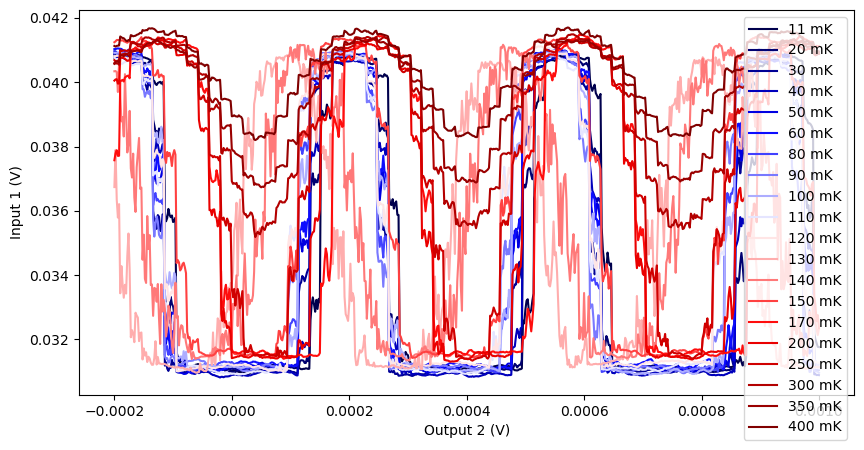

0.00021067808878028784
11: 0
11: 1
11: 2
11: 3
20: 0
20: 1
20: 2
20: 3
30: 0
30: 1
30: 2
30: 3
40: 0
40: 1
40: 2
40: 3
50: 0
50: 1
50: 2
50: 3
60: 0
60: 1
60: 2
60: 3
80: 0
80: 1
80: 2
80: 3
90: 0
90: 1
90: 2
90: 3
100: 0
100: 1
100: 2
100: 3
110: 0
110: 1
110: 2
110: 3
120: 0
120: 1
120: 2
120: 3
130: 0
130: 1
130: 2
130: 3
140: 0
140: 1
140: 2
140: 3
150: 0
150: 1
150: 2
150: 3
170: 0
170: 1
170: 2
170: 3
200: 0
200: 1
200: 2
200: 3
250: 0
250: 1
250: 2
250: 3
300: 0
300: 1
300: 2
300: 3
350: 0
350: 1
350: 2
350: 3
400: 0
400: 1
400: 2
400: 3


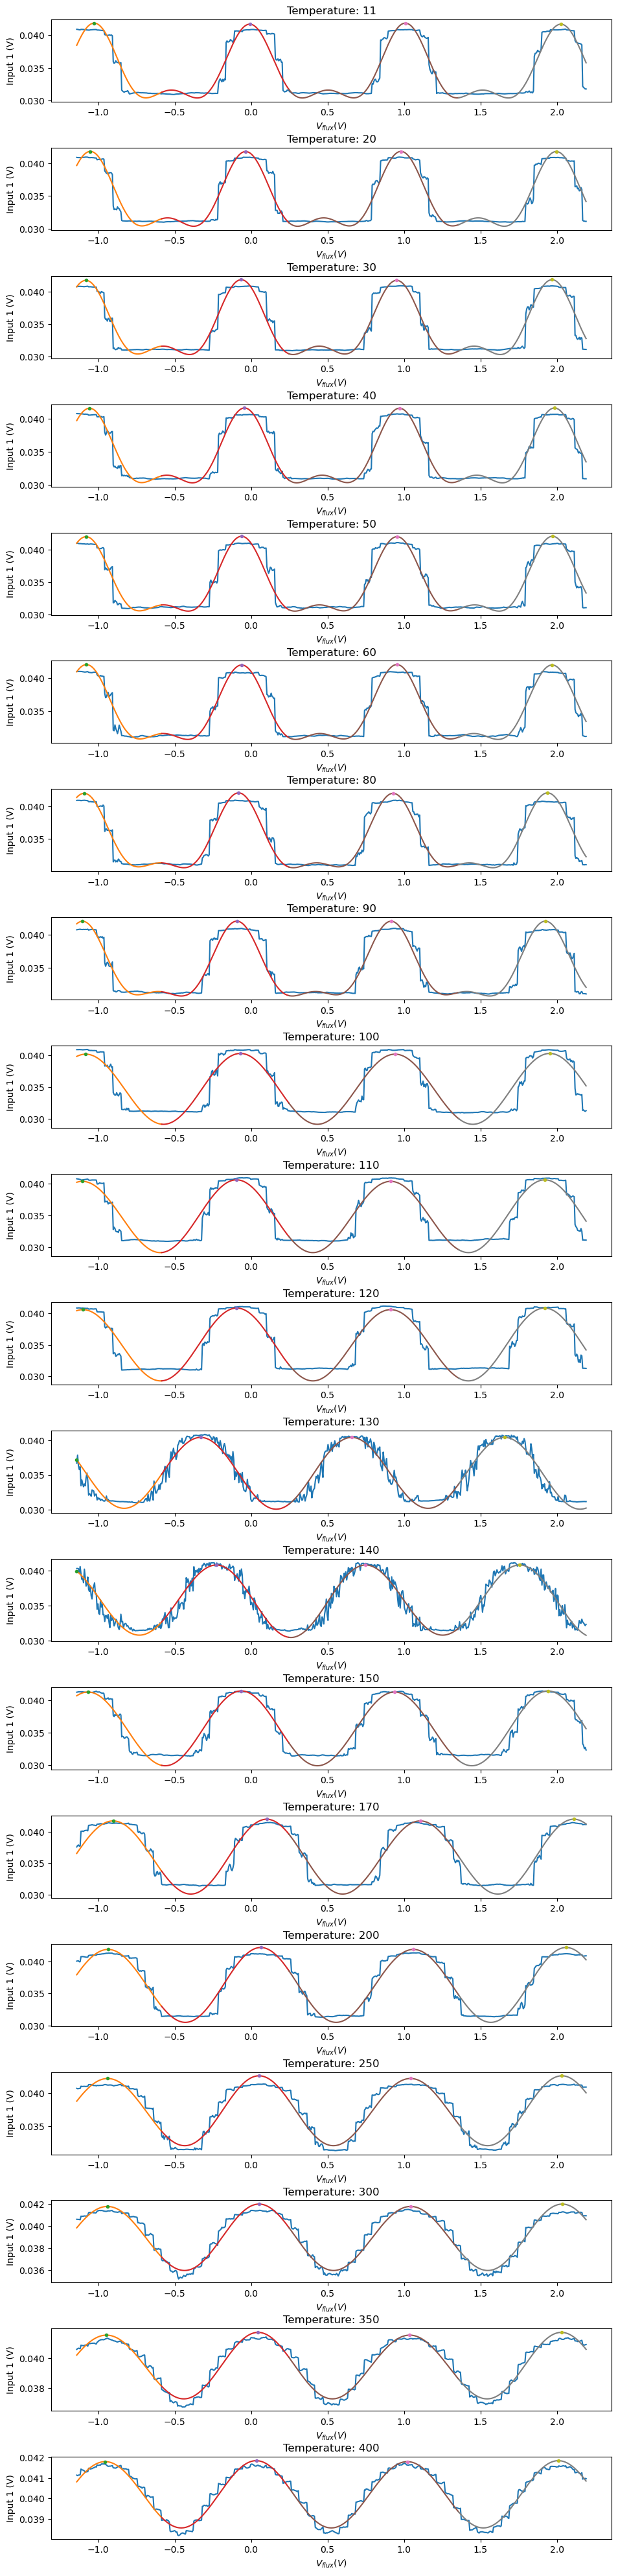

1.017273781647974
1.0156723844235798
1.016224590363026
1.013463560665795
1.0168872374903615
1.0150649578901887
1.0102607662170062
1.0089354719623351
1.0116965016595665
1.00816238364711
1.0064505452348267
0.9881725286391542
0.9763553215350034
1.0027507654405363
1.004296942070986
0.9987196620825785
0.9902709112090498
0.9916514260576661
0.9915962054637213
0.9878964256694309


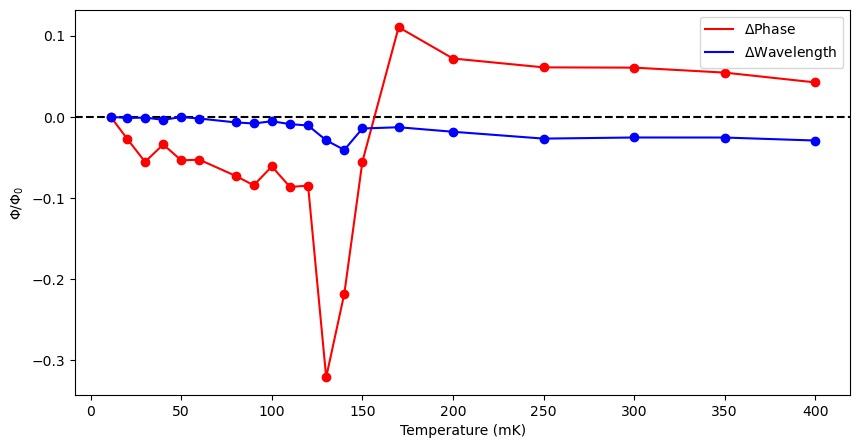

In [53]:
"""
Author: Vamsi
Date Created: 12/07/2023
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.optimize import curve_fit
import re

file_select = pd.read_csv("file_selection.csv", skiprows=1, delimiter="\t")

averaged_df_dict = {}

colors_1 = plt.cm.seismic(np.linspace(0,1,len(file_select["Temperature"].values)))

# Loop through all the temperatures
plt.rcParams["figure.figsize"] = (10,5)
for i, temp in enumerate(file_select["Temperature"]):

    # Read corresponding file for the temperature
    df = pd.read_csv(file_select["Files"][i], delimiter="\t", skiprows=31)
    
    number_of_sweeps_fc = 0
    number_of_sweeps_lid = 0

    forward_current =[]
    LID3 = []
    
    """
    Loops through the corresponding file's columns to find the required column
    Adds the numpy arrays to the corresponding total array for averaging
    """
    for j, col in enumerate(df.columns):
        # Looking for Input 1 for forward sweep data 
        if j!= 0 and re.findall("Input", col) and not re.findall("bwd", col):
            if len(forward_current) == 0:
                forward_current = np.array(df[col].values)
            else:
                forward_current += np.array(df[col].values)
            number_of_sweeps_fc += 1
        # Looking for LI Demod 3 for forward sweep data
        if j!= 0 and re.findall("LI Demod", col) and not re.findall("bwd", col):
            if len(LID3) == 0:
                LID3 = np.array(df[col].values)
            else:
                LID3 += np.array(df[col].values)
            number_of_sweeps_lid += 1
    # Averaging
    forward_current /= number_of_sweeps_fc
    LID3 /= number_of_sweeps_lid

    # Creates a new dataframe of averaged data for convinience and appends to a dictionary of temperatures
    df_new = pd.DataFrame({"Output 2": df[df.columns[0]], "Input 1": forward_current, "LI Demod 3": LID3})
    averaged_df_dict[str(temp)] = df_new
    
    #Plots an overlapping plot of the different temperatures
    plt.plot(df_new["Output 2"], df_new["Input 1"], label = str(temp) + " mK", color = colors_1[i])
    
    plt.xlabel("Output 2 (V)")
    plt.ylabel("Input 1 (V)")
    plt.legend()
plt.show()




first_local_maxima = {}
wavelengths = {}

# Fourier decomposition function
def fourier(x,b, t, amp,  *a):
    ret = a[0] / 2
    for deg in range(1, len(a)):
        ret += a[deg] * np.cos((deg+1) * np.pi / t * (x+b))
    return amp * ret

max_ranges_x = [(-0.0002, 0), (0, 0.0003), (0.0003, 0.0007), (0.0007, 0.001)]

# Rescaling
popt, pcov = curve_fit(fourier, averaged_df_dict["11"]["Output 2"].values, averaged_df_dict["11"]["Input 1"].values, [0.00001, 0.0004, 30]+[1.0] * 5)

xn = np.linspace(np.min(averaged_df_dict["11"]["Output 2"].values), 2*np.max(averaged_df_dict["11"]["Output 2"].values), 100000)
yn = fourier(xn, *popt)
df = pd.DataFrame({
    "X":xn,
    "Y":yn
})
df_temp_1 = df[(df["X"] > max_ranges_x[1][0]) & (df["X"] < max_ranges_x[1][1])]
df_temp_2 = df[(df["X"] > max_ranges_x[2][0]) & (df["X"] < max_ranges_x[2][1])]

phase_1 = df_temp_1.loc[df_temp_1['Y'].idxmax()]["X"]
phase_2 = df_temp_2.loc[df_temp_2['Y'].idxmax()]["X"]

wavelength = (phase_2 - phase_1)
print(phase_1)

# set up 
fig, ax = plt.subplots(len(averaged_df_dict),1)

fig.set_figheight(40)
fig.set_figwidth(10)
fig.tight_layout(pad=3)
i=0
# Loops through averaged dictionary
for key, value in averaged_df_dict.items():
    x = (value["Output 2"].values - phase_1)/wavelength
    y = value["Input 1"].values
    ax[i].plot(x, y)
    
    if int(key) < 100:
        coeff_n = 5
    else:
        coeff_n = 3
    
    # Fit a fourier curve order 2/3
    popt, pcov = curve_fit(fourier, x, y, [0.00001, 0.0004/wavelength, 30]+[1.0] * coeff_n)

    xn = np.linspace(np.min(x), 2*np.max(x), 100000)
    yn = fourier(xn, *popt)
    df = pd.DataFrame({
        "X":xn,
        "Y":yn
    })

    for k, ranges in enumerate(max_ranges_x):     

        df_temp = df[(df["X"] > (ranges[0] - phase_1)/wavelength) & (df["X"] < (ranges[1] - phase_1)/wavelength)]
        local_maximum = df_temp.loc[df_temp['Y'].idxmax()]
        print(key + ": " + str(k))
        #print(local_maximum)

        ax[i].plot(df_temp["X"], df_temp["Y"])
        ax[i].plot(local_maximum["X"], local_maximum["Y"], ".")

        if k == 1:
            first_local_maxima[key] = local_maximum
        if k == 2:
            wavelengths[key] = local_maximum - first_local_maxima[key]
            #print(wavelengths[key])
    ax[i].set_title(f"Temperature: {key}")
    ax[i].set_xlabel("$V_{flux} (V)$")
    ax[i].set_ylabel("Input 1 (V)")
    
    i+=1

    
plt.show()

plt.rcParams["figure.figsize"] = (10,5)
Temp = np.array(list(first_local_maxima.keys()), dtype=int)
Voltage = []
Voltage_Difference = []
for x, y in first_local_maxima.values():
    Voltage.append(x)

for x, y in wavelengths.values():
    print(x)
    Voltage_Difference.append(x)


Voltage = np.array(Voltage)
Voltage = Voltage - Voltage[0]

Voltage_Difference = np.array(Voltage_Difference)
Voltage_Difference = Voltage_Difference - Voltage_Difference[0]


plt.axhline(y=0, color='black', linestyle='--')
plt.plot(Temp, Voltage, "-", color = "red", label = "$\Delta$Phase")
plt.plot(Temp, Voltage, "o", color = "red")
plt.plot(Temp, Voltage_Difference, "-", color = "blue", label = "$\Delta$Wavelength")
plt.plot(Temp, Voltage_Difference, "o", color = "blue")
plt.ylabel("$\Phi / \Phi_0$")
plt.xlabel("Temperature (mK)")
plt.legend()
plt.show()

    